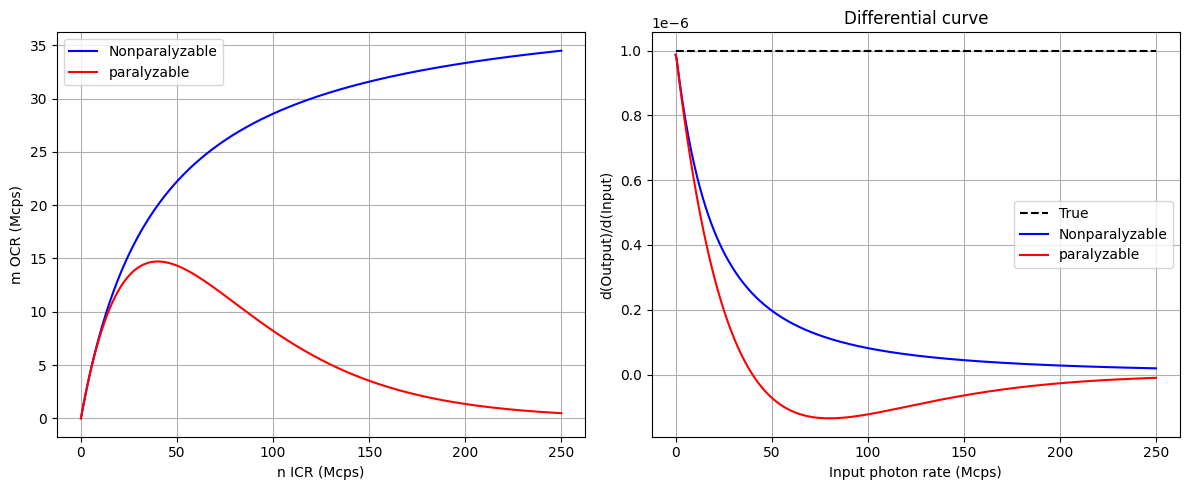

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 参数设置 ----------------
dead_time = 25e-9   # 死时间 100 ns
true_rate = np.linspace(1e0, 250e6, 500)  # 输入光子率 (photons/s)

# ---------------- 真实计数（无死时间） ----------------
counts_true = true_rate

# ---------------- 非瘫痪模式 (Nonparalyzable Model) ----------------
# 输出计数率公式: R_obs = R_true / (1 + R_true * τ)
counts_nonpar = true_rate / (1 + true_rate * dead_time)
counts_par = true_rate * np.exp(- true_rate * dead_time)

# ---------------- 微分曲线 ----------------
diff_true = np.gradient(counts_true, true_rate)
diff_nonpar = np.gradient(counts_nonpar, true_rate)
diff_par = np.gradient(counts_par, true_rate)

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 积分图 (计数率曲线)
plt.subplot(1,2,1)
# plt.plot(true_rate/1e6, counts_true/1e6, 'k--', label="True (no dead time)")
plt.plot(true_rate/1e6, counts_nonpar/1e6, 'b', label="Nonparalyzable")
plt.plot(true_rate/1e6, counts_par/1e6, 'r', label="paralyzable")
plt.xlabel("n ICR (Mcps)")
plt.ylabel("m OCR (Mcps)")
# plt.title("Integral curve")
plt.legend()
plt.grid(True)
 
# 微分图 (增益)
plt.subplot(1,2,2)
plt.plot(true_rate/1e6, diff_true/1e6, 'k--', label="True")
plt.plot(true_rate/1e6, diff_nonpar/1e6, 'b', label="Nonparalyzable")
plt.plot(true_rate/1e6, diff_par/1e6, 'r', label="paralyzable")
plt.xlabel("Input photon rate (Mcps)")
plt.ylabel("d(Output)/d(Input)")
plt.title("Differential curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


模拟光子数: 160000


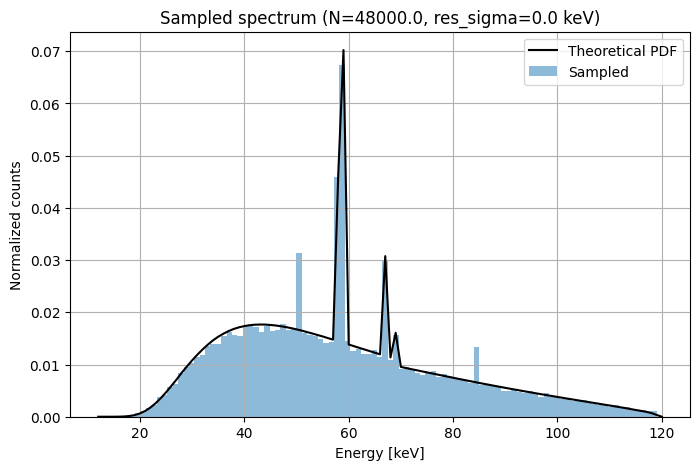

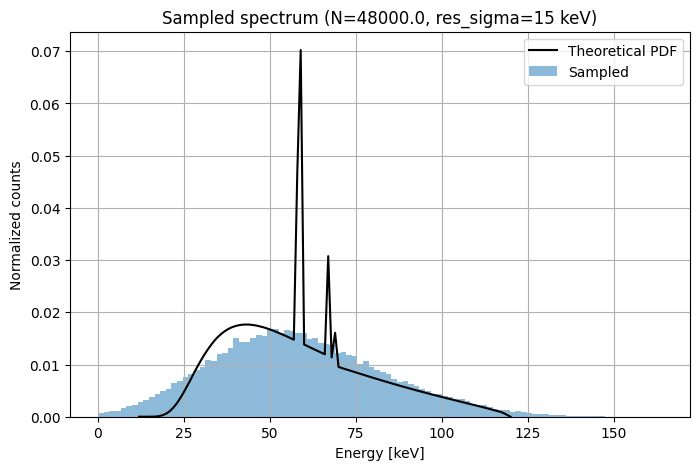

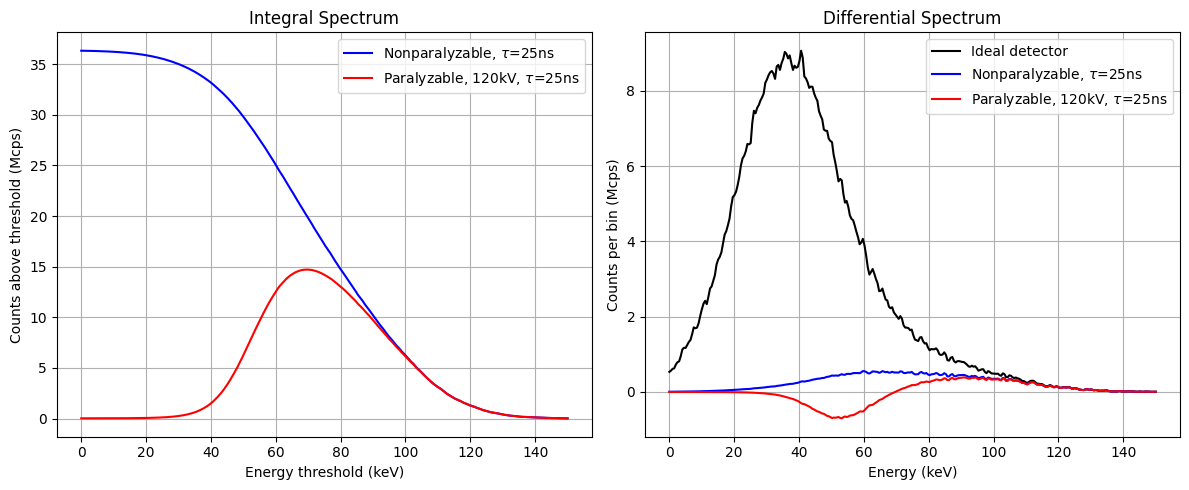

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Spek 光谱读取与信号生成函数 ----------------
def load_signal_from_spek(filename, n_photons, I_mA=1.0, t_s=1.0, 
                          A_pix=0.05*0.05, d=1.0, 
                          res_sigma=0.0, plot=True):
    """
    从 Spek 导出的 txt 文件读取光谱，并生成光子能量分布
    
    参数:
        filename : str, Spek 导出的 txt 文件路径
        n_photons : int, 要模拟的光子数
        I_mA : 管电流 [mA]
        t_s : 曝光时间 [s]
        A_pix : 像素面积 [cm²]
        d : 焦点到探测器距离 [m]
        res_sigma : float, 能量分辨率 (keV)，若 >0 则对光子能量做高斯展宽
        plot : bool, 是否绘制分布图
    
    返回:
        signal_energies : ndarray, 随机采样的光子能量数组
    """
    # 读入数据
    data = np.loadtxt(filename, skiprows=1)
    E = data[:,0]
    flux = data[:,1]   # #/(keV·cm²·mAs)@1m
    
    mAs = I_mA * t_s
    flux_pix = flux * A_pix * (1/d**2) * mAs   # #/keV per pixel
    rate_pix = flux_pix / t_s                  # cps/keV per pixel
    
    # 概率密度分布
    pdf = rate_pix / np.sum(rate_pix)
    
    # 随机采样得到光子能量
    signal_energies = np.random.choice(E, size=int(n_photons), p=pdf)
    
    # 如果设置了能量分辨率，进行高斯展宽
    if res_sigma > 0:
        signal_energies = np.random.normal(signal_energies, res_sigma)
        signal_energies = signal_energies[signal_energies > 0]  # 去掉负能量
    
    # 绘图
    if plot:
        plt.figure(figsize=(8,5))
        # 理论分布
        plt.plot(E, pdf, 'k-', label="Theoretical PDF")
        # 抽样结果直方图
        plt.hist(signal_energies, bins=100, density=True, alpha=0.5, label="Sampled")
        plt.xlabel("Energy [keV]")
        plt.ylabel("Normalized counts")
        title = f"Sampled spectrum (N={n_photons}, res_sigma={res_sigma} keV)"
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return signal_energies



# ---------------- 参数 ----------------
# n_photons = int(1e6)   # 模拟光子数
integral_time = 400e-6  # 积分时间[s]   400（us）
dead_time = 25e-9       # 死时间[s]     15 ns
rate = 400e6             # 最大输入光子率 (photons/s)

n_photons = int(integral_time * rate)
print("模拟光子数:", n_photons)
# ---------------- 信号 + 噪声源 ----------------

# signal = np.random.normal(35, 14, int(0))   # 信号峰
signal = load_signal_from_spek("spek_120.txt", n_photons*0.3, plot=True)  # 30% 信号光子

# 加入能量分辨率模拟：分辨率 5 keV
siggnal_blur = load_signal_from_spek("spek_120.txt", n_photons*0.3, res_sigma=15, plot=True)
# 噪声
noise = np.random.normal(35, 15, int(n_photons*0.7))   # 噪声峰
noise_dark = np.random.normal(65, 5, int(n_photons*0.7))   # 噪声峰

# events = np.concatenate([noise])
# events = np.concatenate([signal, noise])
events = np.concatenate([siggnal_blur, noise])
# events = events[events > 0]   # 去掉负能量


# ---------------- 积分谱计算函数（考虑死时间） ----------------
def integral_spectrum(events, thresholds, tau, T, mode="ideal"):
    spectrum = []
    for thr in thresholds:
        # 阈值以上的光子数
        N_thr = np.sum(events >= thr)
        # 当前输入光子率
        R_thr = N_thr / integral_time  

        if mode == "ideal":
            R_obs = R_thr
        elif mode == "nonpar":
            R_obs = R_thr / (1 + R_thr * tau)
        elif mode == "par":
            R_obs = R_thr * np.exp(-R_thr * tau)
        else:
            raise ValueError("Unknown mode")
        
        # 转换回总计数数目
        spectrum.append(R_obs)
    return np.array(spectrum)

# ---------------- 阈值范围 ----------------
thresholds = np.linspace(0, 150, 300)

# ---------------- 三种模式的积分谱 ----------------
integral_ideal = integral_spectrum(events, thresholds, dead_time, integral_time, mode="ideal")
integral_nonpar = integral_spectrum(events, thresholds, dead_time, integral_time, mode="nonpar")
integral_par_120 = integral_spectrum(events, thresholds, 15e-9, integral_time, mode="par")

integral_par = integral_spectrum(events, thresholds, 25e-9, integral_time, mode="par")
integral_par_noise = integral_spectrum(noise_dark, thresholds, dead_time, integral_time, mode="par")

# ---------------- 微分谱 ----------------
diff_ideal = -np.gradient(integral_ideal, thresholds)
diff_nonpar = -np.gradient(integral_nonpar, thresholds)
diff_par_120 = -np.gradient(integral_par_120, thresholds)
diff_par_noise = -np.gradient(integral_par_noise, thresholds)
diff_par = -np.gradient(integral_par, thresholds)

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 积分谱
plt.subplot(1,2,1)
# plt.plot(thresholds, integral_ideal/1e6, 'k', label="Ideal detector")
plt.plot(thresholds, integral_nonpar/1e6, 'b', label=r"Nonparalyzable, $\tau$=25ns")
plt.plot(thresholds, integral_par/1e6, 'r', label=r"Paralyzable, 120kV, $\tau$=25ns")
# plt.plot(thresholds, integral_par_noise/1e6, 'g', label=r"Paralyzable, dark, $\tau$=25ns")
# plt.plot(thresholds, integral_par_noise/1e6, 'g', label=r"Paralyzable, $\tau$=15ns")
plt.xlabel("Energy threshold (keV)")
plt.ylabel("Counts above threshold (Mcps)")
plt.title("Integral Spectrum")
plt.legend()
plt.grid(True)

# 微分谱
plt.subplot(1,2,2)
plt.plot(thresholds, diff_ideal/1e6, 'k', label="Ideal detector")
plt.plot(thresholds, diff_nonpar/1e6, 'b', label=r"Nonparalyzable, $\tau$=25ns")
plt.plot(thresholds, diff_par/1e6, 'r', label=r"Paralyzable, 120kV, $\tau$=25ns")
# plt.plot(thresholds, diff_par_noise/1e6, 'g', label=r"Paralyzable, dark, $\tau$=25ns")
# plt.plot(thresholds, diff_par_noise/1e6, 'g', label=r"Paralyzable, $\tau$=15ns")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin (Mcps)")
plt.title("Differential Spectrum")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
